Today, an estimated 700,000 people in the United States are living with a primary brain tumor. Brain tumors can be deadly, significantly impact quality of life, and change everything for a patient and their loved ones. They do not discriminate, inflicting men, women, and children of all races and ethnicities.

The ability to detect a tumor earlier, however, when it is smaller, reduces the impact of surgery and treatment, improving the prognosis for many patients.

Thus, we attempt to use brain MRI images to detect whether a brain has tumor or not

In [280]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os #For OS related functions

In [281]:
# Tensorflow / Keras

from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation

import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Image processing

import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version

#Visualization

import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

Tensorflow/Keras: 2.6.0
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.5.4
matplotlib: 3.5.3
graphviz: 0.8.4


### Let's display 1 example of all types of tumor

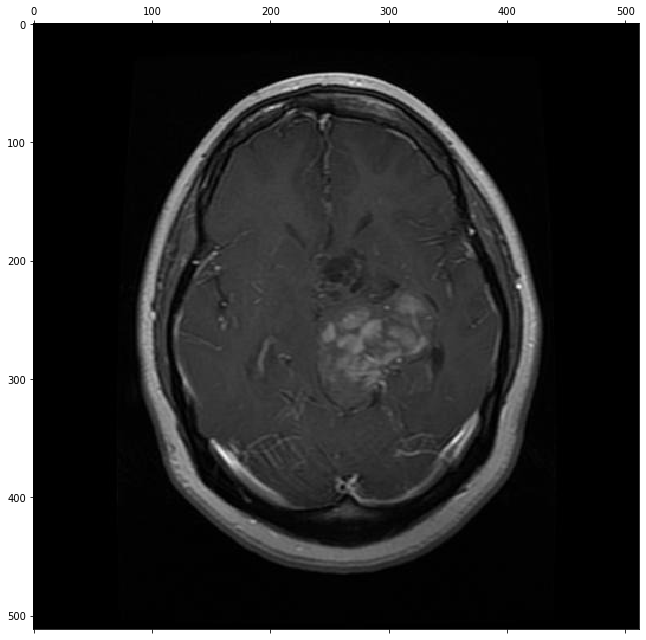

Shape : 
(512, 512, 3)


In [282]:
image = cv2.imread("/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (1).jpg")
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
print("Shape : ")
print(image.shape)

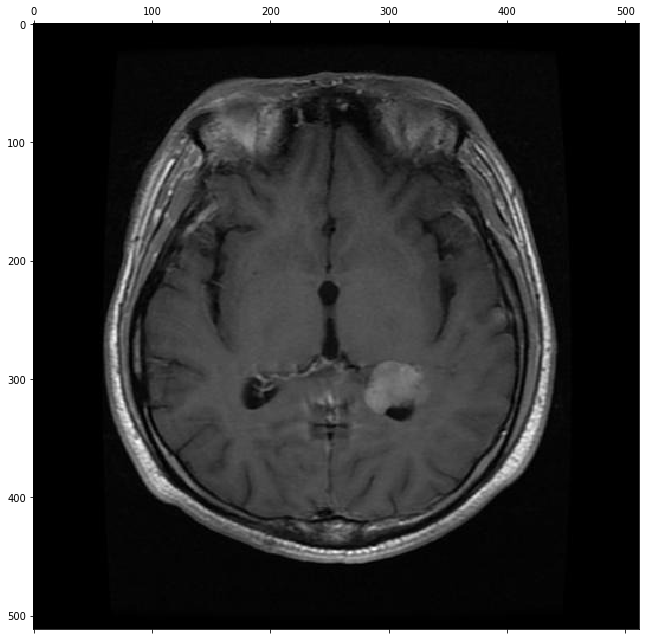

Shape : 
(512, 512, 3)


In [283]:
image = cv2.imread("/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/m (101).jpg")
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
print("Shape : ")
print(image.shape)

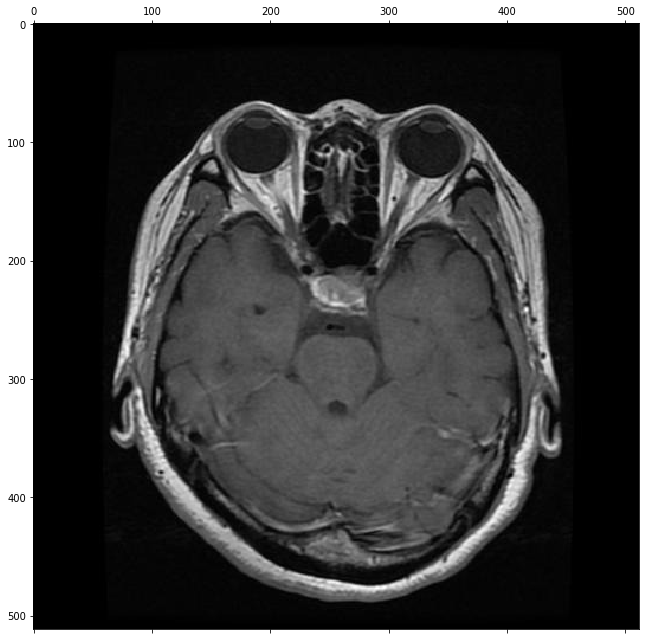

Shape : 
(512, 512, 3)


In [284]:
image = cv2.imread("/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor/p (1).jpg")
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
print("Shape : ")
print(image.shape)

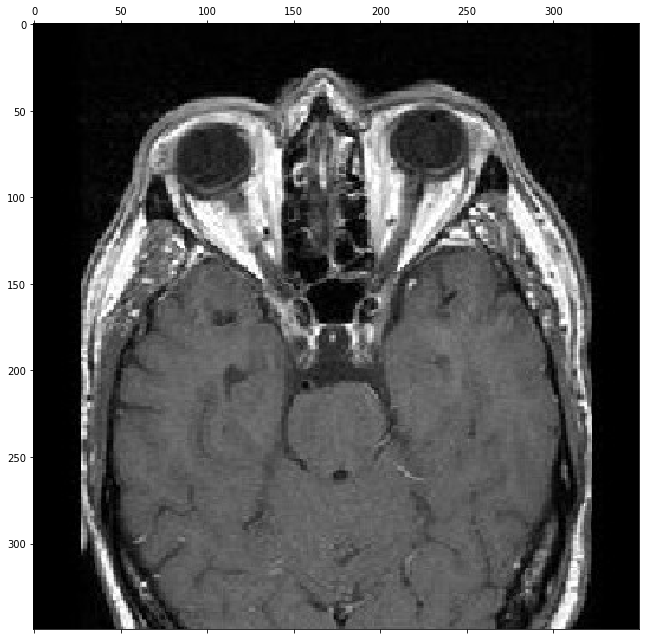

Shape : 
(350, 350, 3)


In [285]:
image = cv2.imread("/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/1.jpg")
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
print("Shape : ")
print(image.shape)

Images seem to have different shapes. We will standarize them below, and also convert images to RGB format

Also, for this walkthrough, we'll consider 2 labels : 

1. 'no' (no_tumor) 

2. 'yes' (glioma_tumor,meningioma_tumor,pituitary_tumor)

Hence, we will classify based on a Brain MRI image whether a patient has Brain Tumor or not

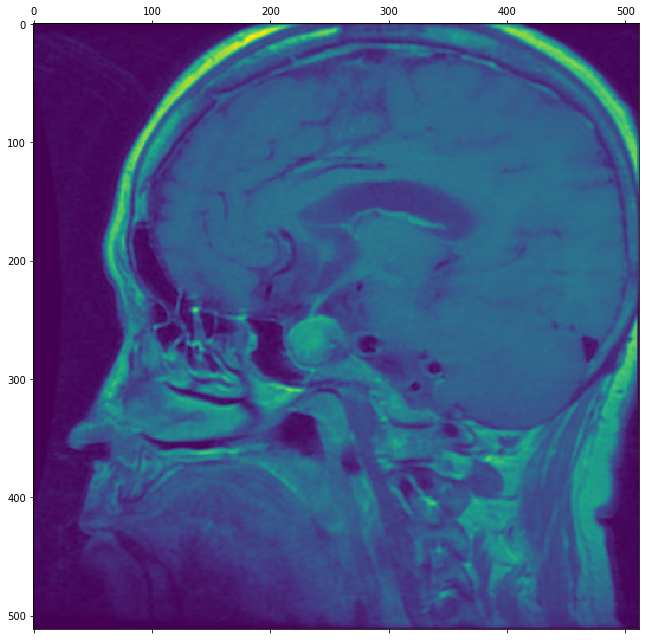

Shape of data_lowres:  (2870, 256, 256)


In [286]:
Tumor_Label = [] 

# Create a list to store image paths and populate Tumor Label Variable

ImagePaths=[]
for tumor_status in ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]:
    count_tumor_status = 0
    ImgLocation = "/kaggle/input/brain-tumor-classification-mri/Training/"+tumor_status
    for image in list(os.listdir(ImgLocation)):
        ImagePaths=ImagePaths+[ImgLocation+"/"+image]
        count_tumor_status += 1
        if tumor_status == "no_tumor":
            Tumor_Label.append("no")
        else:
            Tumor_Label.append("yes")
        
        
# Load images and resize to 256 x 256
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_lowres = cv2.resize(image, (256, 256))
    data_lowres.append(image_lowres)
    
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0
# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

We also need to convert the label from text to numeric format, thus we use get_dummies from Pandas to do so

In [287]:
Tumor_Label = pd.Series(Tumor_Label,name='Tumor_Status')
Tumor_Label = pd.get_dummies(Tumor_Label)

In [288]:
Tumor_Label

,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2865,0,1
2866,0,1
2867,0,1
2868,0,1


In [290]:
data_lowres = data_lowres.reshape(-1,256, 256,1)

In [291]:
print(data_lowres.shape)
print(Tumor_Label.shape)

(2870, 256, 256, 1)
(2870, 2)


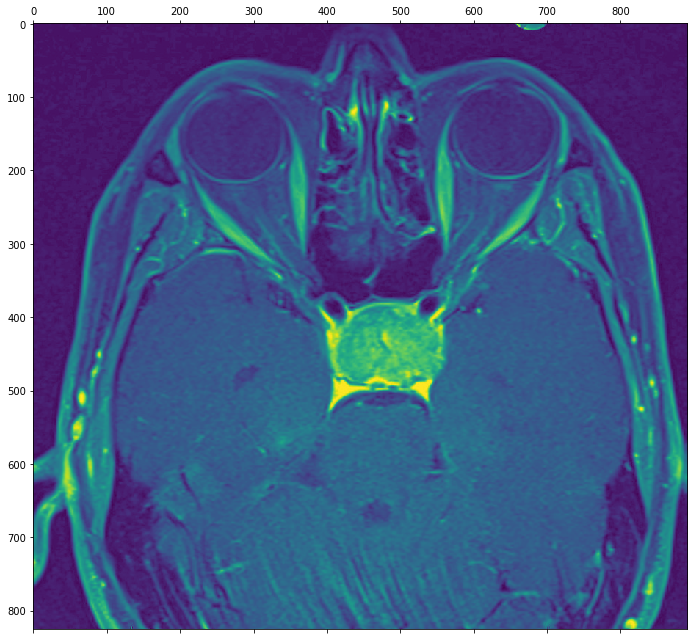

Shape of data_lowres_test:  (394, 256, 256)


In [292]:
Tumor_Label_test = [] 

# Create a list to store image paths and populate Tumor Label Variable

ImagePaths_test=[]
for tumor_status in ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]:
    count_tumor_status = 0
    ImgLocation = "/kaggle/input/brain-tumor-classification-mri/Testing/"+tumor_status
    for image in list(os.listdir(ImgLocation)):
        ImagePaths_test=ImagePaths_test+[ImgLocation+"/"+image]
        count_tumor_status += 1
        if tumor_status == "no_tumor":
            Tumor_Label_test.append("no")
        else:
            Tumor_Label_test.append("yes")
        
        
# Load images and resize to 256 x 256
data_lowres_test=[]
for img in ImagePaths_test:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_lowres = cv2.resize(image, (256, 256))
    data_lowres_test.append(image_lowres)
    
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs.matshow(image)
plt.show() 
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres_test = np.array(data_lowres_test, dtype="float") / 255.0
# Show data shape
print("Shape of data_lowres_test: ", data_lowres_test.shape)

We also need to convert the label from text to numeric format, thus we use get_dummies from Pandas to do so

In [293]:
Tumor_Label_test = pd.Series(Tumor_Label_test,name='Tumor_Status')
Tumor_Label_test = pd.get_dummies(Tumor_Label_test)

In [294]:
Tumor_Label_test

,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
389,0,1
390,0,1
391,0,1
392,0,1


In [295]:
data_lowres_test = data_lowres_test.reshape(-1,256, 256,1)

In [296]:
print(data_lowres_test.shape)
print(Tumor_Label_test.shape)

(394, 256, 256, 1)
(394, 2)


# Convolutional Neural Network

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In the code below, we will design a Convolutional Neural Network from scratch.

In [297]:
from tensorflow.keras import layers

model = keras.Sequential([
    
    layers.InputLayer(input_shape=(256, 256,1)),

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),                  
    layers.MaxPool2D(),    
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),


    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),

    
    # Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),
    
    # Classifier Head
    layers.Flatten(),

    layers.Dense(units=256, activation="relu"),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=2, activation="sigmoid"),
])
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 64, 64, 64)      

In [298]:
# compile the model
model.compile(optimizer='adam', 
loss='binary_crossentropy', 
metrics=['binary_accuracy'])

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# fit the model
history = model.fit(
    data_lowres,
    Tumor_Label,
    validation_data = (data_lowres_test,Tumor_Label_test),
    callbacks=[early_stopping],
    epochs=100,
)

Epoch 1/100
90/90 [==============================] - 5s 50ms/step - loss: 0.4839 - binary_accuracy: 0.8328 - val_loss: 0.7833 - val_binary_accuracy: 0.5000
Epoch 2/100
90/90 [==============================] - 4s 46ms/step - loss: 0.2375 - binary_accuracy: 0.9341 - val_loss: 0.6612 - val_binary_accuracy: 0.6345
Epoch 3/100
90/90 [==============================] - 4s 46ms/step - loss: 0.1510 - binary_accuracy: 0.9505 - val_loss: 1.0249 - val_binary_accuracy: 0.2690
Epoch 4/100
90/90 [==============================] - 4s 46ms/step - loss: 0.1048 - binary_accuracy: 0.9655 - val_loss: 1.1915 - val_binary_accuracy: 0.2690
Epoch 5/100
90/90 [==============================] - 4s 46ms/step - loss: 0.0820 - binary_accuracy: 0.9732 - val_loss: 1.6710 - val_binary_accuracy: 0.2881
Epoch 6/100
90/90 [==============================] - 4s 45ms/step - loss: 0.0666 - binary_accuracy: 0.9760 - val_loss: 0.6628 - val_binary_accuracy: 0.7107
Epoch 7/100
90/90 [==============================] - 4s 46ms/ste

In [303]:
loss, accuracy = model.evaluate(data_lowres_test,Tumor_Label_test)
loss, accuracy

13/13 [==============================] - 0s 14ms/step - loss: 0.4142 - binary_accuracy: 0.9061


(0.41419386863708496, 0.9060913920402527)

<AxesSubplot:>

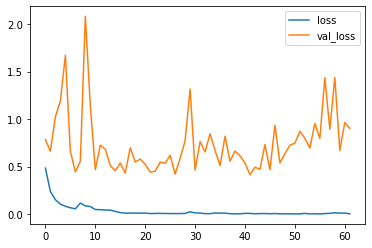

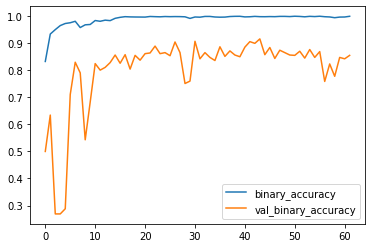

In [301]:
history_df = pd.DataFrame(history.history)

# extract the accuracy values from the history object
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

### We have a model that predicts whether a patient has Brain Tumor or not with ~91% validation accuracy